# Session 04 DQN - Assignment


In deep Q-learning, we use a neural network to approximate the Q-value function. The state is given as an input to the neural network. 
The output of the neural network represents the (estimated) Q-values of all possible actions. Using an argmax, we choose the action corresponding to the highest Q-value.


To train the Q network, we sample a batch of stored experiences from the replay memory. An experience is a tuple of (state, action, reward, next_state).
We input the state into the Q network and get the estimated Q-values. For the Q network to adjust the weights, it needs to have an idea of how accurate these predicted Q-values are.
However, we do not know the target or actual value here as we are dealing with a reinforcement learning problem. The solution is to estimate the target value by using a second neural network, called the target network. This target network will take the next state as an input and predict the Q-values for all possible actions from that state. 
Now we can compute the labels $y$ to train the policy network: $y = R(s, a) + \gamma max_{a'}Q(s', a') - Q_{t-1}(s, a)$.

The Q network can now be trained with the MSE loss. It's important to know that the target network is an exact copy of the policy network and the weights of the target network 

After a certain amount of Q-network updates, we copy its weights to the target network.

For more detailed information: https://www.analyticsvidhya.com/blog/2019/04/introduction-deep-q-learning-python/



In [2]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
import collections

# Import Tensorflow libraries

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from IPython.display import HTML

# NN-model visualisation
from keras_sequential_ascii import keras2ascii


## MountainCar-V0

A car is on a one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum.
The agent (a car) is started at the bottom of a valley. For any given state the agent may choose to accelerate to the left, right or cease any acceleration.

<img src="./NotebookImages/MountainCart.gif">

For a description of the statevector, the action space and the episode termination,have a look at:https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py

- Implement a DQN to solve this environment.
- Try to minimize the total number of steps per episode needed to reach the flag.
- You are allowed to tweak the reward function. For example, giving an extra reward for getting closer to the flag.
- Modify the DQN implementation into a deep SARSA implementation. Compare the deep SARSA to the DQN implementation.

In [3]:
# Define the Replay memory class and the Agent Class

class ReplayMemory:
    def __init__(self, max_size):
        self.memory = collections.deque(maxlen=max_size)

    def add(self, experience):
        self.memory.append(experience)
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    
# Define the DQN agent class

class DQNAgent:
    def __init__(self, env, sarsa=False):
        self.env = env
        self.sarsa = sarsa
        print("Environment: {}".format(self.env.spec.id))
        print("Observation space: {}".format(self.env.observation_space))
        print("Action space: {}".format(self.env.action_space))
        self.memory = ReplayMemory(max_size=10000)
        self.gamma = 0.8
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.977
        self.learning_rate = 0.001
        print("Q-model:")
        self.model = self.create_model()
        print("Target Q-model:")
        self.target_model = self.create_model()
        self.UPDATE_TARGET_INTERVAL = 600
        self.update_target_model()
    
    def create_model(self):
        model = Sequential()
        model.add(Dense(64, input_shape=(self.env.observation_space.shape[0],), activation="relu"))
        model.add(Dense(64, activation="relu"))
        model.add(Dense(self.env.action_space.n))
        model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=self.learning_rate))
        keras2ascii(model)
        return model
    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
        print("Target model updated")
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.model.predict(state.reshape(1,-1), verbose=0)[0])
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) >= batch_size:
            experiences = self.memory.sample(batch_size)
            
            batch_states = np.asarray(list(zip(*experiences))[0],dtype=float)
            batch_actions = np.asarray(list(zip(*experiences))[1],dtype=int)
            batch_rewards = np.asarray(list(zip(*experiences))[2],dtype=float)
            batch_next_states = np.asarray(list(zip(*experiences))[3],dtype=float)
            batch_done = np.asarray(list(zip(*experiences))[4],dtype=bool)
            
            current_state_q_values = self.model.predict(batch_states, verbose=0)
            y = current_state_q_values

            next_state_q_values = self.model.predict(batch_next_states, verbose=0)
            
            if self.sarsa == True:
                q_next_state = np.zeros(batch_size)
                for i in range(batch_size):
                    if random.random() <= self.epsilon:
                        q_next_state[i] = next_state_q_values[i][random.randint(0,2)]
                    else:
                        q_next_state[i] = np.max(next_state_q_values[i])
            else:    
                q_next_state = np.max(next_state_q_values, axis=1)

            for i in range(batch_size):
                if batch_done[i]:
                    y[i,batch_actions[i]] = batch_rewards[i]
                else:
                    y[i,batch_actions[i]] = batch_rewards[i] + self.gamma * q_next_state[i]

            self.model.fit(batch_states, y, batch_size=batch_size, verbose=0)
        else:
            pass
        #self.update_epsilon()
    
    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def save(self, name):
        self.model.save_weights(name)
        print("Model saved")

    def load(self, name):
        self.model.load_weights(name)
        self.update_target_model()
        print("Model loaded")
    
    def reward_function(self, reward, next_state):
        reward = reward + abs(next_state[0]+0.5) + abs(10*next_state[1])**2
        if next_state[0] >= 0.5:
            reward += 200
        return reward
    
    def test(self, episodes):
        rewards = []
        steps = []
        self.epsilon = 0 # no exploration in test phase
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0
            stepCounter = 0
            done = False
            while not done:
                self.env.render()
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                reward = self.reward_function(reward, next_state)
                total_reward += reward
                state = next_state
                stepCounter += 1
            rewards.append(total_reward)
            steps.append(stepCounter)
            print("Episode: {}, Total Reward: {}".format(episode, total_reward))
        return rewards, steps  
    
    def train(self, episodes, batch_size):
        rewards = []
        steps = []
        updateCounter = 0
        stepCounter = 0
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0
            stepCounter = 0
            done = False
            while not done:
                self.env.render()
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                reward = self.reward_function(reward, next_state)
                total_reward += reward
                self.remember(state, action, reward, next_state, done)
                state = next_state
                self.replay(batch_size)
                stepCounter += 1
            rewards.append(total_reward)
            steps.append(stepCounter)
            self.update_epsilon()
            if updateCounter == self.UPDATE_TARGET_INTERVAL:
                self.update_target_model()
                print('target updated')
                updateCounter = 0
            updateCounter += 1
            print("Episode: {}, Total Reward: {}, Epsilon: {}".format(episode, total_reward, self.epsilon))
        return rewards, steps  
    

Environment: MountainCar-v0
Observation space: Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
Action space: Discrete(3)
Q-model:
           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           2
               Dense   XXXXX -------------------       192     4.2%
                relu   #####          64
               Dense   XXXXX -------------------      4160    91.5%
                relu   #####          64
               Dense   XXXXX -------------------       195     4.3%
                       #####           3
Target Q-model:
           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           2
               Dense   XXXXX -------------------       192     4.2%
                relu   #####          64
               Dense   XXXXX -------------------      4160    91.5%
                relu   #####          64
               Dense   XXXXX -------------------       195     4.3%

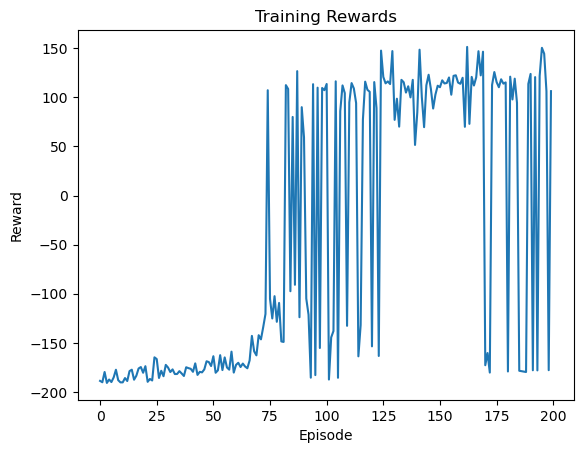

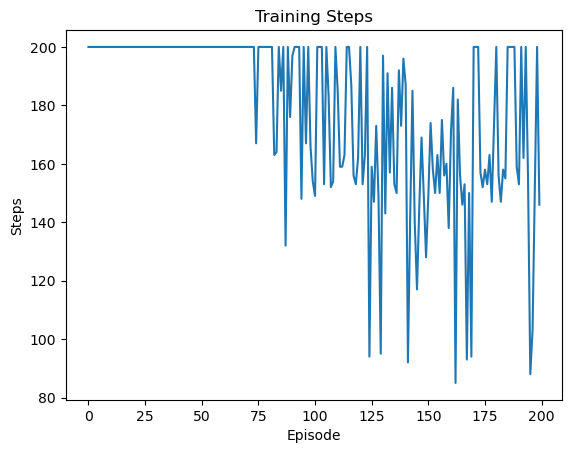

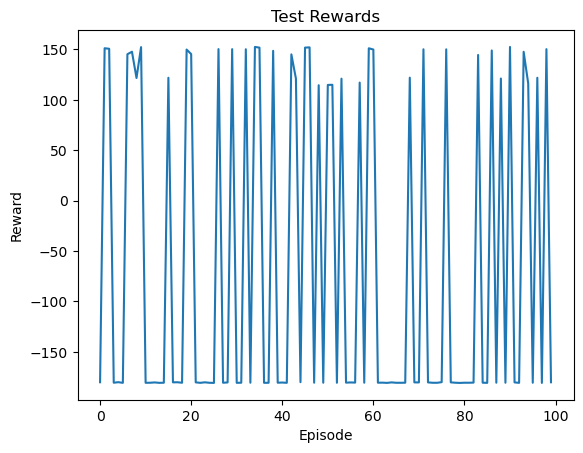

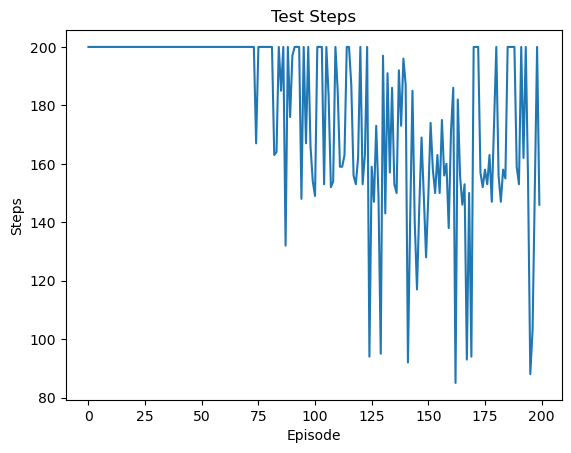

Model saved


In [7]:
# Solve the MountainCar environment with DQN

env = gym.make("MountainCar-v0")
env.reset()

# Define the agent

agent = DQNAgent(env, sarsa=False)

# Train the agent

rewards, steps = agent.train(episodes=200, batch_size=256)

# Test the agent

test_rewards, test_steps = agent.test(episodes=100)

# Close the environment

env.close()

# Plot the training rewards

plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training Rewards")
plt.show()

plt.plot(steps)
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("Training Steps")
plt.show()

# Plot the test rewards

plt.plot(test_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Test Rewards")
plt.show()

plt.plot(steps)
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("Test Steps")
plt.show()
# Save the agent

agent.save("savedmodels\mountaincar-dqn.h5")

# Load the agent

# agent.load("mountaincar-dqn.h5")

Environment: MountainCar-v0
Observation space: Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
Action space: Discrete(3)
Q-model:
           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           2
               Dense   XXXXX -------------------       192     4.2%
                relu   #####          64
               Dense   XXXXX -------------------      4160    91.5%
                relu   #####          64
               Dense   XXXXX -------------------       195     4.3%
                       #####           3
Target Q-model:
           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           2
               Dense   XXXXX -------------------       192     4.2%
                relu   #####          64
               Dense   XXXXX -------------------      4160    91.5%
                relu   #####          64
               Dense   XXXXX -------------------       195     4.3%

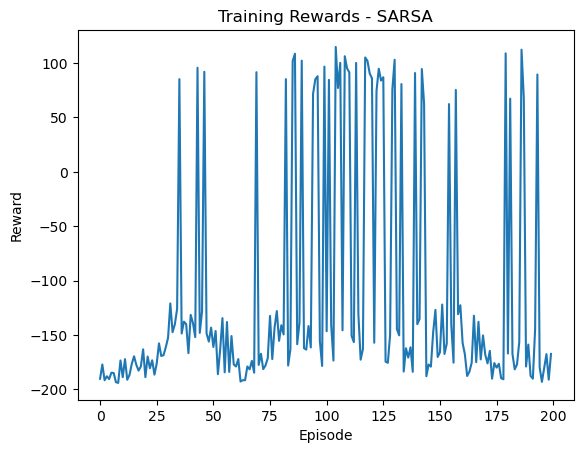

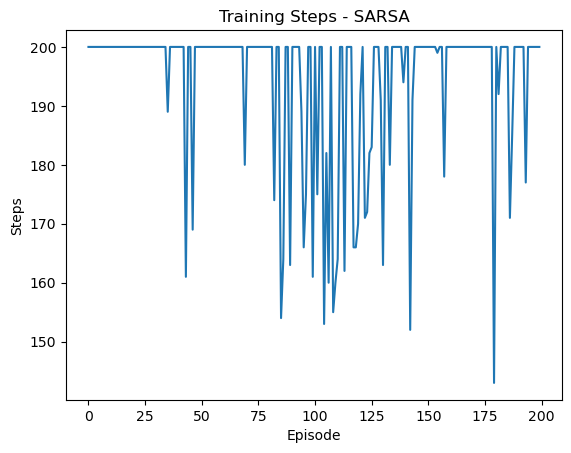

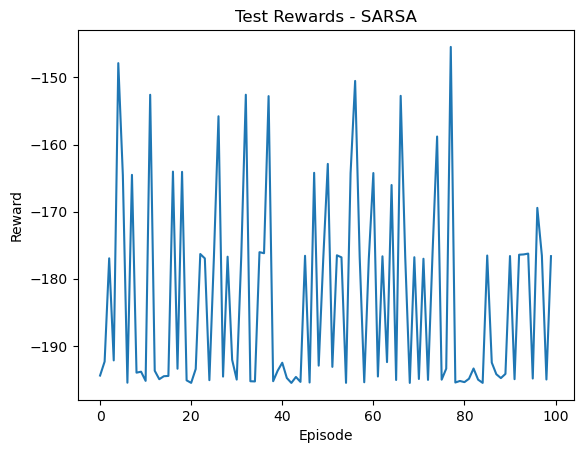

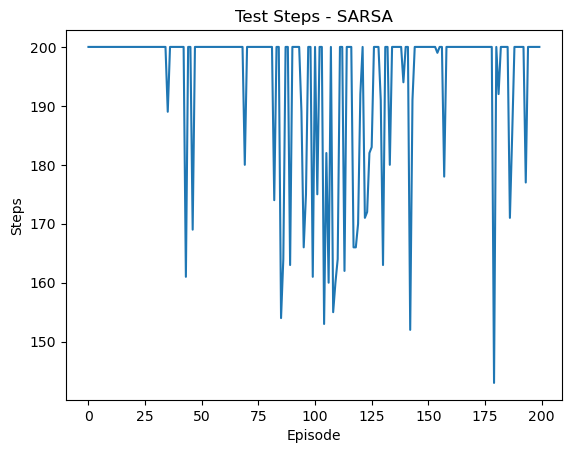

Model saved


In [8]:
# Solve the MountainCar environment with Deep SARSAS

env = gym.make("MountainCar-v0")
env.reset()

# Define the agent

agent = DQNAgent(env, sarsa=True)

# Train the agent

rewards, steps = agent.train(episodes=200, batch_size=256)

# Test the agent

test_rewards, test_steps = agent.test(episodes=100)

# Close the environment

env.close()

# Plot the training rewards

plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training Rewards - SARSA")
plt.show()

plt.plot(steps)
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("Training Steps - SARSA")
plt.show()

# Plot the test rewards

plt.plot(test_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Test Rewards - SARSA")
plt.show()

plt.plot(steps)
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("Test Steps - SARSA")
plt.show()

# Save the agent

agent.save("savedmodels\mountaincar-dqn-sarsa.h5")

# Load the agent

# agent.load("mountaincar-dqn.h5")

# Conclusions Mountain car

### DQN vs Deep SARSA (DSA)
- First successful episode 
   - DQN at episode 75
   - DSA at episode 30
   => DSA trains faster (45 episodes earlier) but 'forgets' also fast

- Training consistency
   - Both DQN and SARSA show high fluctuations in outcome, sometimes the environment is solved and the next episode it fails again.
   - DQN has a good training between episode 125 and 170 and ends in average outcome
   - DSA show high fluctuations and ends with bad episodes, the test results are not good

- Training time
   - Both approaches have in general the same training time

- Conclusion
   - Both show the same progress, DSA shows faster a good result but has the tendency to forget the learned progress


## LunarLander-v2

Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.
For more information abou this environment see: https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py

<img src="./NotebookImages/LunarLander.gif">

- Implement a DQN to solve this environment. LunarLander-v2 defines "solving" as getting average reward of 200 over 100 consecutive trials. 
- Try to minimize the number of episodes it takes to solve the environment.
- How would you tweak the reward function for the LunarLander to make a quicker descent.
- Modify the DQN implementation into a deep SARSA implementation. Compare the deep SARSA to the DQN implementation.

In [5]:
# Take the agent class from the Mountaincar and change the reward_function

class LunarDQNAgent(DQNAgent):
    def __init__(self, env, sarsa=False):
        super().__init__(env, sarsa)
        self.UPDATE_TARGET_INTERVAL = 2000

    def reward_function(self, reward, next_state):
        return reward

Environment: LunarLander-v2
Observation space: Box(-inf, inf, (8,), float32)
Action space: Discrete(4)
Q-model:
           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           8
               Dense   XXXXX -------------------       576    11.5%
                relu   #####          64
               Dense   XXXXX -------------------      4160    83.3%
                relu   #####          64
               Dense   XXXXX -------------------       260     5.2%
                       #####           4
Target Q-model:
           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           8
               Dense   XXXXX -------------------       576    11.5%
                relu   #####          64
               Dense   XXXXX -------------------      4160    83.3%
                relu   #####          64
               Dense   XXXXX -------------------       260     5.2%
                       ##### 

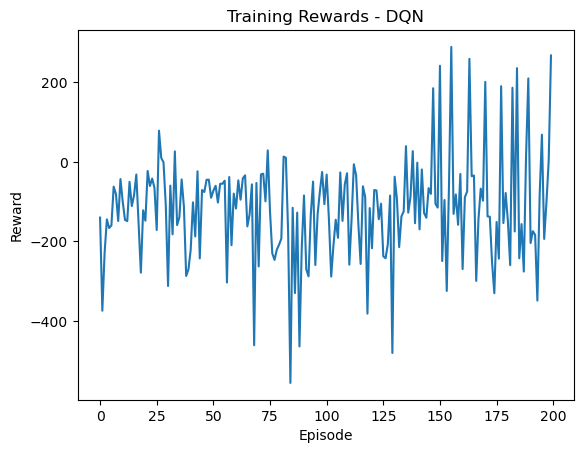

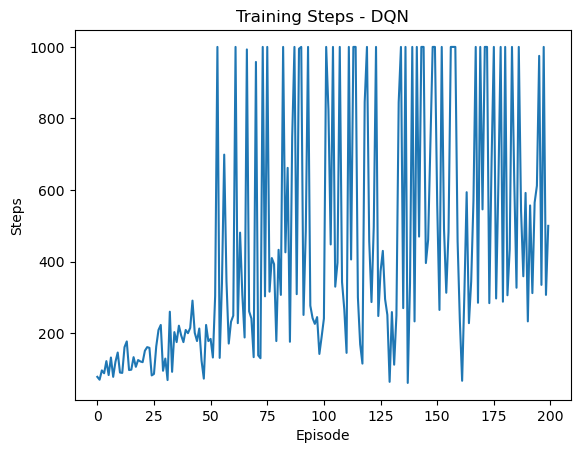

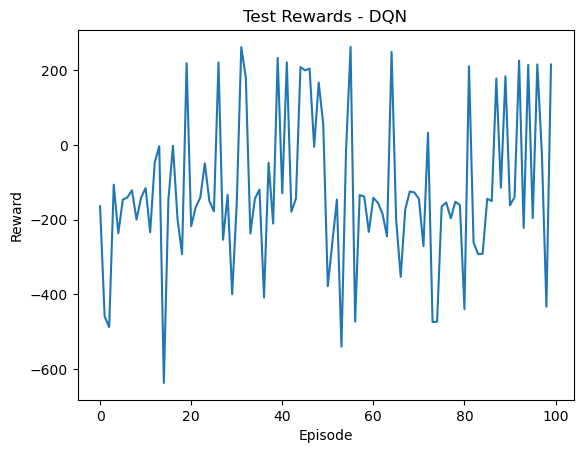

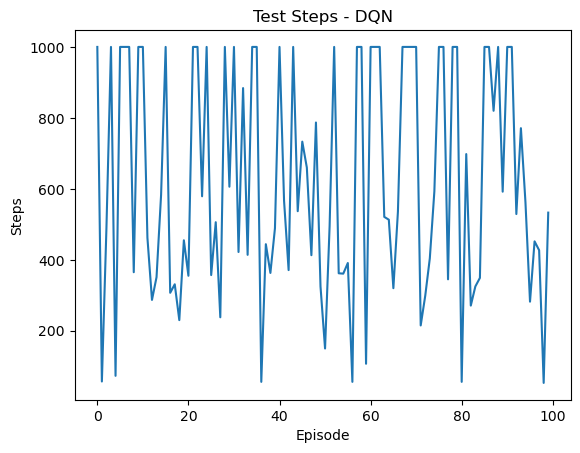

Model saved


In [7]:
# Solve the LunarLander environment with DQN

env = gym.make("LunarLander-v2")
env.reset()

# Define the DQNagent

agent = LunarDQNAgent(env)

# Train the agent

rewards, steps = agent.train(episodes=200, batch_size=512)

# Test the agent

test_rewards, test_steps = agent.test(episodes=100)

# Close the environment

env.close()

# Plot the training rewards

plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training Rewards - DQN")
plt.show()

plt.plot(steps)
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("Training Steps - DQN")
plt.show()

# Plot the test rewards

plt.plot(test_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Test Rewards - DQN")
plt.show()

plt.plot(test_steps)
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("Test Steps - DQN")
plt.show()

# Save the agent

agent.save("savedmodels\lunarlander-dqn.h5")

# Load the agent

# agent.load("lunarlander-dqn.h5")

# First thoughts on Lunar Lander - DQN
- Since the steps in one episode can take up to 1000, the update interval of the target network was increased to 1000 (but maybe still to fast)
- The increase in training steps shows the fact that the Agent learns to slow down the Lander during landing
- Around episode 150 the first successful landing is accomplished!


Environment: LunarLander-v2
Observation space: Box(-inf, inf, (8,), float32)
Action space: Discrete(4)
Q-model:
           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           8
               Dense   XXXXX -------------------       576    11.5%
                relu   #####          64
               Dense   XXXXX -------------------      4160    83.3%
                relu   #####          64
               Dense   XXXXX -------------------       260     5.2%
                       #####           4
Target Q-model:
           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           8
               Dense   XXXXX -------------------       576    11.5%
                relu   #####          64
               Dense   XXXXX -------------------      4160    83.3%
                relu   #####          64
               Dense   XXXXX -------------------       260     5.2%
                       ##### 

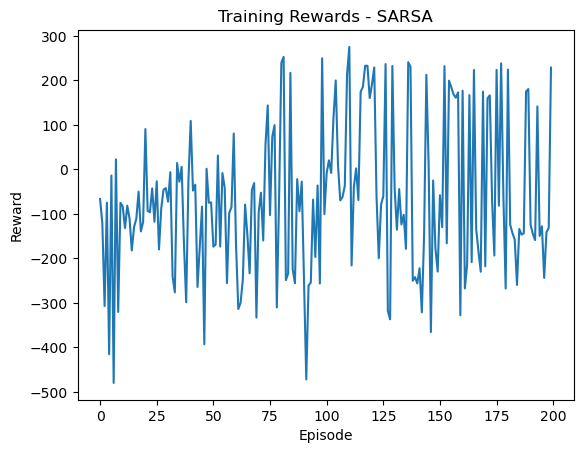

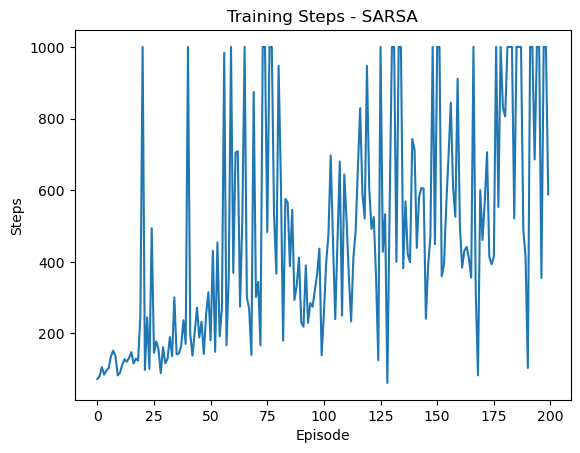

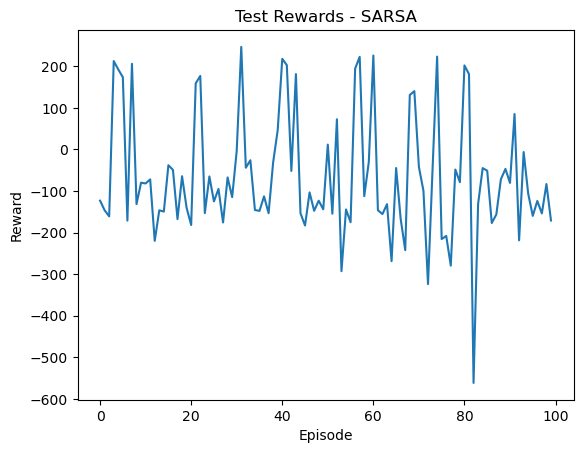

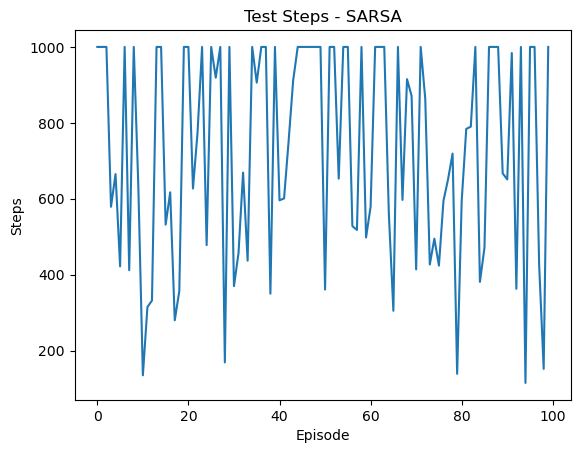

Model saved


In [9]:
# Solve the LunarLander environment with SARSA

env = gym.make("LunarLander-v2")
env.reset()

# Define the SARSA agent

agent = LunarDQNAgent(env, sarsa=True)

# Train the agent

rewards, steps = agent.train(episodes=200, batch_size=64)

# Test the agent

test_rewards, test_steps = agent.test(episodes=100)

# Close the environment

env.close()

# Plot the training rewards

plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training Rewards - SARSA")
plt.show()

plt.plot(steps)
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("Training Steps - SARSA")
plt.show()

# Plot the test rewards

plt.plot(test_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Test Rewards - SARSA")
plt.show()

plt.plot(test_steps)
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("Test Steps - SARSA")
plt.show()

# Save the agent

agent.save("savedmodels\lunarlander-deepsarsa.h5")

# Load the agent

# agent.load("lunarlander-dqn.h5")

# Conclusions Lunar Lander

### DQN vs Deep SARSA (DSA)
- DSA has its first successful landing arround episode 75 while DQN arround 150
- The test for DSA was consistently higher than for DQN
- Both models haven't solved the environment (no 100 consecutive steps with 200 points)

### Changing the reward
Increase the penalty for firing the main engine from -0.3 to -1 or -2.
In 1000 steps this gives a difference of -700 points.